# Data Analysis for NSF Grant

## Import files

In [4]:
import pandas as pd
import numpy as np

# Import nltk and download stopwords if first time.
# import nltk 
# nltk.download('stopwords')
import nltk
from nltk.corpus import stopwords, webtext, PlaintextCorpusReader
import inflect
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt


C:\Users\jinch\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\jinch\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

## Filtering Methods

## Remove null values for abstract and division_code

In [5]:
def remove_null(df):
    df1 = df.copy()
    df1 = df[pd.notnull(df['abstract'])]
    df1 = df[pd.notnull(df['division_code'])]   
    return df1

## Filtering irrelevant grants

In [6]:
def filter_grants(df):
    df1 = df.copy() 
    # Filter irrelevant grants
    df1 = df1[~df1['ProgramReference'].apply(lambda x: 'REU SUPP-Res Exp for Ugrd Supp' in x)]
    df1 = df1[~df1['ProgramReference'].apply(lambda x: 'RET SITE-Res Exp for Tchr Site' in x)]
    df1 = df1[~df1['ProgramReference'].apply(lambda x: 'Improv Undergrad STEM Ed(IUSE)' in x)]
    df1 = df1[~df1['ProgramReference'].apply(lambda x: 'UNDERGRADUATE EDUCATION' in x)]
    df1 = df1[~df1['ProgramReference'].apply(lambda x: 'CONFERENCE AND WORKSHOPS' in x)]
    df1 = df1[~df1['ProgramReference'].apply(lambda x: 'HBCU-Strengthening Research Capacities' in x)]
    df1 = df1[~df1['title'].str.contains("REU", case = False)]
    df1 = df1[~df1['title'].str.contains("SBIR", case = False)]
    df1 = df1[~df1['title'].str.contains("STTR", case = False)]
    df1 = df1[~df1['title'].str.contains("conference", case = False)]
    # Alternative: df = df[df['title'].str.contains("conference", case = False) == False]
    
    if df1['abstract'].str.contains("REU", case = False).any():
        df1 = df1[df1['abstract'].str.contains("REU", case = False) == False]
    df1 = df1[~df1['abstract'].str.contains("SBIR", case = False)]
    df1 = df1[~df1['abstract'].str.contains("STTR", case = False)]
    df1 = df1[~df1['abstract'].str.contains("conference", case = False)]
    # Removes duplicate titles. These are same research under different PIs
    df1.drop_duplicates(subset=['title'], inplace=True)
    
    return df1

## Clean title to be the last two elements of a ":" separated list

In [7]:
# This function removes the program categories that are meaningless to the titles
def clean_title(title):
    if(":" not in title):
        return title
    split_title = title.split(":")
    title_with_last_two = split_title[-2:]
    first_element = title_with_last_two[0]
    last_element = title_with_last_two[1]
    split_first_element = first_element.split()

    if(len(split_first_element) > 1):
        if (("Excellence in Research" in first_element) or
            ("ECR EIE DCL" in first_element) or
            ("Research Initiation Award" in first_element) or
            ("RET Site" in first_element) or
            ("Collaborative Research" in first_element) or
            ("ECR DBER DCL" in first_element) or
            ("Catalyst Project" in first_element) or
            ("COLLABORATIVE RESEARCH" in first_element) or
            ("REU Site" in first_element)    
            ):
            return last_element
        return (":").join(title_with_last_two)
    return last_element

def clean_title_df(df):
    df1 = df.copy()
    df1['title'] = df1['title'].apply(clean_title)
    return df1

## Remove meaningless words

In [8]:
# This is different from filter_grants because filter_grants method removes the entire row,
# whereas this function removes specific words in the title so that it will not count its
# frequency.

def remove_irrelevent(df, keywords):
    df1 = df.copy()
    df1.title = df1.title.apply(lambda x: [word for word in x if word not in keywords])
    df1.abstract = df1.abstract.apply(lambda x: [word for word in x if word not in keywords])
    return df1

## Filter stopwords

Filtering function retrieved from stackoverflow: https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas

In [9]:
def filter_stopwords(df):
    stop = stopwords.words('english')
    df1 = df.copy()
    # This function removes all characters except dash symbol   
    punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{}~'   # `|` is not present here
    transtab = str.maketrans(dict.fromkeys(punct, ''))
    df1['title'] = '|'.join(df1['title'].tolist()).translate(transtab).split('|')
    df1['abstract'] = '|'.join(df1['abstract'].tolist()).translate(transtab).split('|')
    
    # Convert to lower case
    df1['title'] = df1['title'].apply(lambda x: x.lower())
    df1['abstract'] = df1['abstract'].apply(lambda x: x.lower())
    
    # Remove stopwords
    df1['title'] = df1['title'].apply(lambda x: [item for item in x.split() if item not in stop])
    df1['abstract'] = df1['abstract'].apply(lambda x: [item for item in x.split() if item not in stop])
    df1.reset_index(drop=True, inplace=True)
    return df1

## Load csv and convert to df

In [10]:
df_2021 = pd.read_csv('years_csv/df_2021.csv', index_col=0)
df_2020 = pd.read_csv('years_csv/df_2020.csv', index_col=0)
df_2019 = pd.read_csv('years_csv/df_2019.csv', index_col=0)
df_2018 = pd.read_csv('years_csv/df_2018.csv', index_col=0)
df_2017 = pd.read_csv('years_csv/df_2017.csv', index_col=0)
df_2016 = pd.read_csv('years_csv/df_2016.csv', index_col=0)
df_2015 = pd.read_csv('years_csv/df_2015.csv', index_col=0)
df_2014 = pd.read_csv('years_csv/df_2014.csv', index_col=0)
df_2013 = pd.read_csv('years_csv/df_2013.csv', index_col=0)
df_2012 = pd.read_csv('years_csv/df_2012.csv', index_col=0)
df_2011 = pd.read_csv('years_csv/df_2011.csv', index_col=0)
df_2010 = pd.read_csv('years_csv/df_2010.csv', index_col=0)
df_2009 = pd.read_csv('years_csv/df_2009.csv', index_col=0)
df_2008 = pd.read_csv('years_csv/df_2008.csv', index_col=0)
df_2007 = pd.read_csv('years_csv/df_2007.csv', index_col=0)

In [11]:
df_2021

,award_id,title,amount,institution,effective_date,expiration_date,abstract,program_element_code,program_element_name,directorate,division_code,division_name,investigator,state_name,state_code,ProgramReference
0,2100003,CI CoE: Demo Pilot: Advancing Research Computi...,1497243,INTERNET2,05/15/2021,04/30/2023,Research is increasingly dependent upon Cyberi...,7231,CYBERINFRASTRUCTURE,CSE,OAC,Office of Advanced Cyberinfrastructure (OAC),Thomas E Cheatham,District of Columbia,DC,"['WOMEN, MINORITY, DISABLED, NEC']"
1,2100012,Increasing the Number and Diversity of Cyberse...,299792,Robeson Community College,05/01/2021,04/30/2024,The US Bureau of Labor Statistics projects tha...,7412,Advanced Tech Education Prog,EHR,DUE,Division Of Undergraduate Education,Michael L Jacobs,North Carolina,NC,"['COVID-Disproportionate Impcts Inst-Indiv', '..."
2,2100013,CIF: Small: Learning To Correct Errors,491424,University of Arizona,10/01/2021,09/30/2024,Error-correcting codes play an essential role ...,7797,Comm & Information Foundations,CSE,CCF,Division of Computing and Communication Founda...,Bane Vasic,Arizona,AZ,"['SMALL PROJECT', 'COMM & INFORMATION THEORY',..."
3,2100014,Power of Us: Increasing Female Enrollment and ...,288951,Durham Technical Community College,10/15/2021,09/30/2024,The low participation of women in technical fi...,7412,Advanced Tech Education Prog,EHR,DUE,Division Of Undergraduate Education,Charlene West,North Carolina,NC,"['COVID-Disproportionate Impcts Inst-Indiv', '..."
4,2100015,CAREER: Amplifying Developer-Written Tests for...,203890,Northeastern University,09/01/2020,04/30/2024,Code injection vulnerabilities are a class of ...,8060,Secure &Trustworthy Cyberspace,CSE,CNS,Division Of Computer and Network Systems,Jonathan Bell,Massachusetts,MA,"['SaTC: Secure and Trustworthy Cyberspace', 'C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,2147125,RAPID: North Dakota Field Measurement Campaign...,45000,University of North Dakota Main Campus,08/15/2021,07/31/2022,Fog is a high-impact weather hazard over many ...,1525,Physical & Dynamic Meteorology,GEO,AGS,Div Atmospheric & Geospace Sciences,David J Delene,North Dakota,ND,"['RAPID', 'EXP PROG TO STIM COMP RES']"
6169,2147189,"Inviscid Limits, Uniqueness, and Anomalous Dis...",124477,Florida International University,09/01/2021,08/31/2024,"Turbulence, the complex, irregular and chaotic...",1266,APPLIED MATHEMATICS,MPS,DMS,Division Of Mathematical Sciences,Hakima Bessaih,Florida,FL,['EXP PROG TO STIM COMP RES']
6170,2147417,IAA Audit,10272,Department of Interior,09/01/2021,09/01/2022,NaN,0636,NaN,IRM,HRM,Division Of Human Resource Management,Richard H Benson,RI REQUIRED,NaN,[]
6171,2147546,Collaborative Research: Fine-Grained Statistic...,59999,University of Pennsylvania,07/01/2022,06/30/2023,Emerging data science applications require eff...,1269,STATISTICS,MPS,DMS,Division Of Mathematical Sciences,Yuting Wei,Pennsylvania,PA,['Machine Learning Theory']


## Combine all filtering methods

In [12]:
def filter(df):
    df1 = df.copy()
    
    # Drop abstracts/division code that are null
    df1 = remove_null(df1)
    
    # Working with Division of Computer and Network System
    df1 = df1[df1['division_code'].str.contains("CNS") == True] 

    # Filters irrelevant grants
    df1 = filter_grants(df1)
    
    # Filters title with categories of programs
    df1 = clean_title_df(df1)   
    
    # Filters stopwords
    df1 = filter_stopwords(df1)

    # Remove keywords
    keywords = ['track','iucrc','research','scc-cvic-pg','scc-civic-pg', 'using', 'toward', 'student','broader','impacts',
                'intellectual','merit','support','evaluation','award','reflects','nsfs','statutory','mission','deemed',
                'worthy','foundation','review','criteria','project','aims','high','school','also','undergraduate','graduate',
                'new','b','nsf','next','department','state','university','united','states','grant','planning','collaboration',
                'challenge','innovation','professional','wide','range','publicly','available','made','available','large',
                'number','novel','communities','curriculum','centers','broadening','participation','k-12', 'brings', 'together',
               'whole', 'part', 'american', 'plan', 'part', 'best', 'i-corps', 'i-corp']
    
    df1 = remove_irrelevent(df1, keywords)
    return df1

In [13]:
df_2021_filtered = filter(df_2021)
df_2020_filtered = filter(df_2020)
df_2019_filtered = filter(df_2019)
df_2018_filtered = filter(df_2018)
df_2017_filtered = filter(df_2017)
df_2016_filtered = filter(df_2016)
df_2015_filtered = filter(df_2015)
df_2014_filtered = filter(df_2014)
df_2013_filtered = filter(df_2013)
df_2012_filtered = filter(df_2012)
df_2011_filtered = filter(df_2011)
df_2010_filtered = filter(df_2010)
df_2009_filtered = filter(df_2009)
df_2008_filtered = filter(df_2008)
df_2007_filtered = filter(df_2007)

In [14]:
def get_df_year(year):    
    dispatcher = {'2021': df_2021_filtered,
                  '2020': df_2020_filtered,
                  '2019': df_2019_filtered,
                  '2018': df_2018_filtered,
                  '2017': df_2017_filtered,
                  '2016': df_2016_filtered,
                  '2015': df_2015_filtered,
                  '2014': df_2014_filtered,
                  '2013': df_2013_filtered,
                  '2012': df_2012_filtered,
                  '2011': df_2011_filtered,
                  '2010': df_2010_filtered,
                  '2009': df_2009_filtered,
                  '2008': df_2008_filtered,
                  '2007': df_2007_filtered}
    
    return dispatcher[year]

## Count frequency of words

In [15]:
# Filter plural words. Count method calls upon this function
def get_singular(plural_noun):
    p = inflect.engine()
    plural = p.singular_noun(plural_noun)
    if (plural):
        return plural
    else:
        return plural_noun

In [16]:
# Find frequency of each word in a string in Python using dictionary.   
# If there exists a word then simply
# increase the word's frequency.
def count(elements, dictionary):
    
    # Gets the word in singular form. If the word ends with two ss, 
    # it will skil the get_singular function (i.e. wireless)
    if (elements[-2:] == "ss") or (elements[-2:] == "is"):
        singular_form = elements
    else:
        singular_form = get_singular(elements)
        
    if singular_form in dictionary:
        dictionary[singular_form] += 1
   
    # If the dictionary does not have the key as "elements" 
    # then create a key "elements" and assign its value to 1.
    else:
        dictionary.update({singular_form: 1}) 

In [17]:
# Return a dictionary of entire frequencies

def dict_frequency(df, column):
    dictionary = {} 
    for rows in df[column]:
        # Take each word from lst and pass it to the method count.
        for elements in rows:
            count(elements, dictionary)
            
    sorted_dict = sorted(dictionary.items(), key=lambda x: x[1], reverse=True) 
    
    return sorted_dict

In [18]:
# Return a dictionary of frequencies for a single row

def dict_frequency_row(series, column):
    dictionary = {} 
    # Take each word from lst and pass it to thh count method.
    for elements in series[column]:
        count(elements, dictionary)
            
    sorted_dict = sorted(dictionary.items(), key=lambda x: x[1], reverse=True) 
    
    return sorted_dict

## Create a dataframe of frequency count

In [19]:
# Return a dataframe of frequency of each word in the title
def title_freq_single(df):
    df1 = df.copy()
    # Find frequency of each word in the title
    freq_title = dict_frequency(df1, 'title')
    df_frq_title = pd.DataFrame(freq_title)
    df_frq_title.set_axis(['Word','Frequency'], axis=1, inplace=True)
    df_frq_title.reset_index(drop=True, inplace=True)

    return df_frq_title

# Return a dataframe of frequency of each word in the abstract
def abstract_freq_single(df):
    df1 = df.copy()
    # Find frequency of each word in the title
    freq_abstract = dict_frequency(df1, 'title')
    df_frq_abstract = pd.DataFrame(freq_abstract)
    df_frq_abstract.set_axis(['Word','Frequency'], axis=1, inplace=True)
    df_frq_abstract.reset_index(drop=True, inplace=True)

    return df_frq_abstract

title_2021_one_word = title_freq_single(get_df_year('2021'))
title_2020_one_word = title_freq_single(get_df_year('2020'))
title_2019_one_word = title_freq_single(get_df_year('2019'))

abstract_2021_one_word = abstract_freq_single(get_df_year('2021'))
abstract_2020_one_word = abstract_freq_single(get_df_year('2020'))
abstract_2019_one_word = abstract_freq_single(get_df_year('2019'))

## Plot single word frequency counts

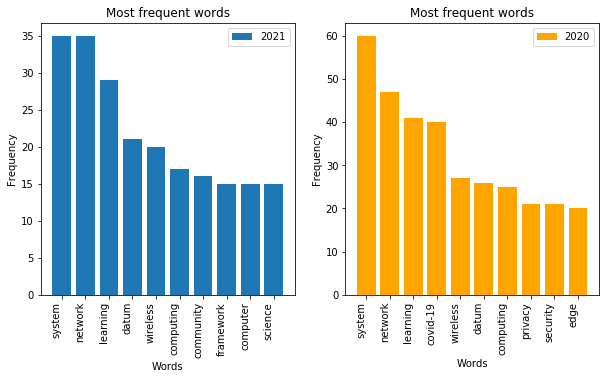

In [20]:
df1 = title_2021_one_word.iloc[:10]
df2 = title_2020_one_word.iloc[:10]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(df1['Word'], df1['Frequency'], width = 0.8, label='2021')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most frequent words")
plt.xticks(rotation=90, ha="right")
plt.legend()

plt.subplot(1,2,2)
plt.bar(df2['Word'], df2['Frequency'], width = 0.8, label='2020', color='orange')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most frequent words")
plt.xticks(rotation=90, ha="right")
plt.legend()

plt.show()

# Gets frequent two-three word phrases

In [21]:
# use to find bigrams, which are pairs of words
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from operator import itemgetter

In [22]:
"""
get_phrases() takes arguments: 
1) required positional argument: a data frame,
2) a variable number of column titles,
3) optional keyword argument: the length of a phrase (1-3 words), default is 2 
"""
def get_phrases(df, *args, num_words=2):
    columns = [*args]
    # Creates a list of words for context
    word_list = []
    freq_list = []
    for column in columns:
        for rows in df[column]:
            for words in rows:
                word_list.append(words.lower())

    # Runs the library that counts most frequent phrases
    if(num_words == 1):
        return dict_frequency(df, column)
    if(num_words == 2):
        bigram_collocation = BigramCollocationFinder.from_words(word_list)
        # only bigrams that appear 3+ times
        bigram_collocation.apply_freq_filter(3)
        #Gets the top bigrams with PMI Scores
        for k,v in bigram_collocation.ngram_fd.items():
              freq_list.append((k,v))
        freq_list = [(' '.join(values[0]), values[1]) for values in freq_list]

    if(num_words == 3):
        freq_list = []
        trigram_collocation = TrigramCollocationFinder.from_words(word_list)
        # only trigrams that appear 3+ times
        trigram_collocation.apply_freq_filter(3)
        freq_list = []
        for k,v in trigram_collocation.ngram_fd.items():
              freq_list.append((k,v))
        freq_list = [(' '.join(values[0]), values[1]) for values in freq_list]       
        
    freq_list.sort(key=itemgetter(1), reverse=True)
    return freq_list

# Get list top TWO word phrases with frequencies for a given df

In [23]:
# Get top two-word phrases for title
top_two_phrase_title_2021 = get_phrases(get_df_year('2021'), 'title', num_words=2)
top_two_phrase_title_2020 = get_phrases(get_df_year('2020'), 'title', num_words=2)
top_two_phrase_title_2019 = get_phrases(get_df_year('2019'), 'title', num_words=2)
top_two_phrase_title_2018 = get_phrases(get_df_year('2018'), 'title', num_words=2)
top_two_phrase_title_2017 = get_phrases(get_df_year('2017'), 'title', num_words=2)
top_two_phrase_title_2016 = get_phrases(get_df_year('2016'), 'title', num_words=2)
top_two_phrase_title_2015 = get_phrases(get_df_year('2015'), 'title', num_words=2)
top_two_phrase_title_2014 = get_phrases(get_df_year('2014'), 'title', num_words=2)
top_two_phrase_title_2013 = get_phrases(get_df_year('2013'), 'title', num_words=2)
top_two_phrase_title_2012 = get_phrases(get_df_year('2012'), 'title', num_words=2)
 
# Get top two-word phrases for abstract
top_two_phrase_abstract_2021 = get_phrases(get_df_year('2021'), 'abstract', num_words=2)
top_two_phrase_abstract_2020 = get_phrases(get_df_year('2020'), 'abstract', num_words=2) 
top_two_phrase_abstract_2019 = get_phrases(get_df_year('2019'), 'abstract', num_words=2) 
top_two_phrase_abstract_2018 = get_phrases(get_df_year('2018'), 'abstract', num_words=2) 
top_two_phrase_abstract_2017 = get_phrases(get_df_year('2017'), 'abstract', num_words=2) 
top_two_phrase_abstract_2016 = get_phrases(get_df_year('2016'), 'abstract', num_words=2) 
top_two_phrase_abstract_2015 = get_phrases(get_df_year('2015'), 'abstract', num_words=2) 
top_two_phrase_abstract_2014 = get_phrases(get_df_year('2014'), 'abstract', num_words=2) 
top_two_phrase_abstract_2013 = get_phrases(get_df_year('2013'), 'abstract', num_words=2) 
top_two_phrase_abstract_2012 = get_phrases(get_df_year('2012'), 'abstract', num_words=2) 
top_two_phrase_abstract_2011 = get_phrases(get_df_year('2011'), 'abstract', num_words=2) 
top_two_phrase_abstract_2010 = get_phrases(get_df_year('2010'), 'abstract', num_words=2) 
top_two_phrase_abstract_2009 = get_phrases(get_df_year('2009'), 'abstract', num_words=2) 
top_two_phrase_abstract_2008 = get_phrases(get_df_year('2008'), 'abstract', num_words=2) 
top_two_phrase_abstract_2007 = get_phrases(get_df_year('2007'), 'abstract', num_words=2) 

# Get list of top THREE word phrases with frequencies for a given df

In [24]:
# Get top two-word phrases for title
top_three_phrase_title_2021 = get_phrases(df_2021_filtered, 'title', num_words=3)
top_three_phrase_title_2020 = get_phrases(df_2020_filtered, 'title', num_words=3)
top_three_phrase_title_2019 = get_phrases(df_2019_filtered, 'title', num_words=3)
top_three_phrase_title_2018 = get_phrases(df_2018_filtered, 'title', num_words=3)
top_three_phrase_title_2017 = get_phrases(df_2017_filtered, 'title', num_words=3)
top_three_phrase_title_2016 = get_phrases(df_2016_filtered, 'title', num_words=3)
top_three_phrase_title_2015 = get_phrases(df_2015_filtered, 'title', num_words=3)
top_three_phrase_title_2014 = get_phrases(df_2014_filtered, 'title', num_words=3)
top_three_phrase_title_2013 = get_phrases(df_2013_filtered, 'title', num_words=3)
top_three_phrase_title_2012 = get_phrases(df_2012_filtered, 'title', num_words=3)

# Get top two-word phrases for abstract
top_three_phrase_abstract_2021 = get_phrases(df_2021_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2020 = get_phrases(df_2020_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2019 = get_phrases(df_2019_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2018 = get_phrases(df_2018_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2017 = get_phrases(df_2017_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2016 = get_phrases(df_2016_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2015 = get_phrases(df_2015_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2014 = get_phrases(df_2014_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2013 = get_phrases(df_2013_filtered, 'abstract', num_words=3)
top_three_phrase_abstract_2012 = get_phrases(df_2012_filtered, 'abstract', num_words=3)

# Plotting Frequency of Two and Three Word Phrases

In [25]:
"""
Plots two bar graphs, one for two-worded phrases 
and another for three-worded phrases.
argument: list of two-worded phrases, three-worded phrases
"""
def plot_phrases(two_word_phrases, three_word_phrases):
    two_word_x_values = [values[0] for values in two_word_phrases[:5]]
    two_word_y_values = [values[1] for values in two_word_phrases[:5]]
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.bar(two_word_x_values, two_word_y_values,
            width = 0.8, label='Two Words')
    plt.xlabel("Two Word Phrases")
    plt.ylabel("Frequency")
    plt.title("Top 5 Two Word Phrases")
    plt.xticks(rotation=90, ha="right")
    plt.legend()
    # plt.legend(bbox_to_anchor=(1,1), loc="upper left")

    three_word_x_values = [' '.join(values[0]) for values in three_word_phrases[:5]]
    three_word_y_values = [values[1] for values in three_word_phrases[:5]]

    plt.subplot(1,2,2)
    plt.bar(three_word_x_values, three_word_y_values,
            width = 0.8, label='Three Words', color='purple')
    plt.xlabel("Three Word Phrases")
    plt.ylabel("Frequency")
    plt.title("Top 5 Three Word Phrases")
    plt.xticks(rotation=90, ha="right")
    plt.legend()
    # plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

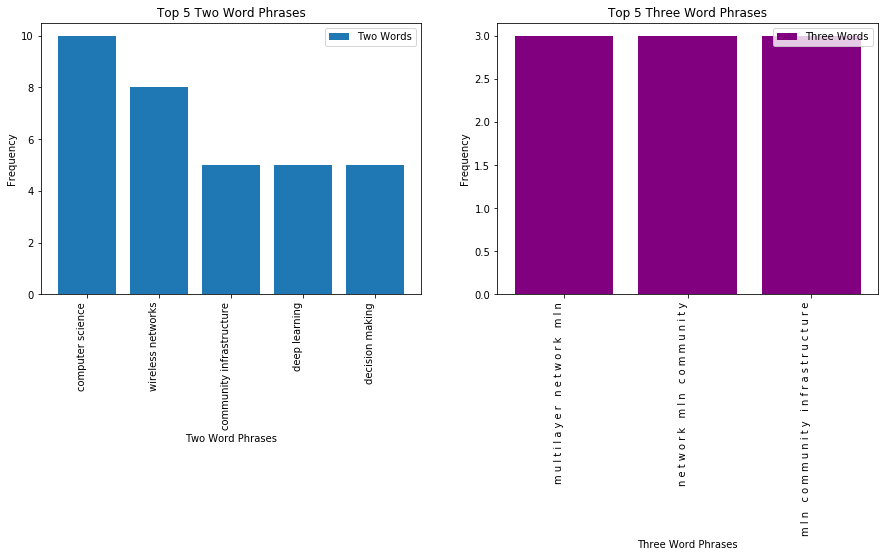

In [26]:
plot_phrases(top_two_phrase_title_2021,top_three_phrase_title_2021)

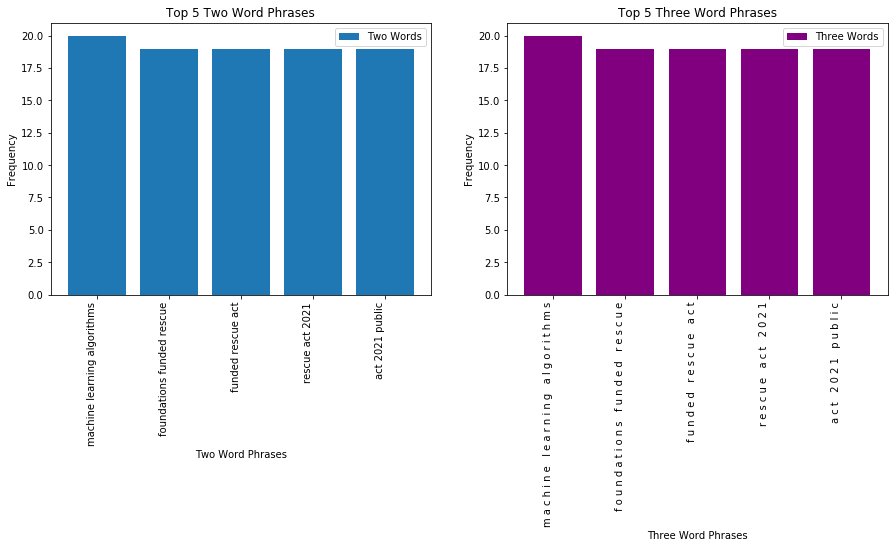

In [27]:
plot_phrases(top_three_phrase_abstract_2021, top_three_phrase_abstract_2021)

# Generate a dataframe of word frequencies

In [28]:
import seaborn as sns

C:\Users\jinch\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [29]:
def get_two_word(word_list):
    freq_list = []
    
    bigram_collocation = BigramCollocationFinder.from_words(word_list)
    
    for k,v in bigram_collocation.ngram_fd.items():
          freq_list.append((k,v))
    freq_list = [(' '.join(values[0]), values[1]) for values in freq_list]
    return freq_list

"""
Creates a data frame with keyword list as columns 
and add the frequency of the keyword per each row.
Args:
df - dataframe that we are working with
keywords_list - the keywords generated from get_phrases
num_keyword - number of keyword to find frequency for
"""
def df_of_keyword(df, keywords_list, num_keyword):  
   
    # Create a copy of df
    df1 = df.copy()

    # Iterate through dataframe
    for index, row in df1.iterrows():

        # Get the bigram of abstract information of a row
        rows_bigram = get_two_word(row['abstract'] + row['title'])
        
        # Iterate through the top frequent words that we have generated previously
        for phrase in keywords_list[:num_keyword]:
            
            # Get column name of top keywords by combining first element of the tuple
            column = phrase[0]

            # Iterate through the row abstracts bigram
            for row_phrase_abstract in rows_bigram:
                
                # Compare if the keyword is in the row abstracts bigram
                if (phrase[0] == row_phrase_abstract[0]):
    
                    # If keyword is in the row abstract, set the frequency
                    df1.loc[index, column] = row_phrase_abstract[1]
    
    # Fill NaN with zeros and get columns of keyword
#     df1 = df1.iloc[:,-num_keyword:].fillna(0)
    df1 = df1.fillna(0)
    
#     # Add effective_date column
#     df1.insert(loc=0, column='effective_date', value=df.effective_date)
    
    # Set effective_date as datetime
    df1['effective_date'] = pd.to_datetime(df.effective_date)
    
    # Sort and reset index
    df1.sort_values(by=['effective_date'], inplace=True, ascending=False)
    df1.reset_index(drop=True, inplace=True)
    return df1

## Filtering additional keywords per year

In [76]:
"""
This method removes phrases that are irrelevant to the research study.
Args:
year_list: list of keywords and frequency as a tuple in a list
Return: year_list
"""
def remove_phrases(year_list):

    phrases = ['learning algorithms', 'funded rescue', '2021 public', 'act 2021', 'public law', 'science engineering', 
               'foundations funded', 'things iot', 'securitybrbrthis foundations', 'goal develop', 'outreach activities',
               'science technology', 'learning techniques', 'underrepresented groups', 'national network', 
               'networking opportunities', 'technology engineering', 'chest center', 'proposed work', 'five years',
               'thrust first', 'second thrust', 'recent years', 'five years, smart connected', 'underrepresented students',
               'address challenges', 'quality life', 'rescue act', 'community members', 'decision making', 
               'science engineering', 'future internet', 'technology concepts', 'underrepresented groups', 'transition work',
               'opportunities training', 'software tools', 'foundations impactcommercial', 'contribute national', 
               'significant impact', 'work marketplace', 'impactcommercial potential', 'researchers entrepreneurs', 
               'enable groups', 'hardware software', 'spectrum access', 'teams transition', 'industry partners',
               'formal verification', 'distributed systems', 'real time', 'data collected', 'design implementation',
               'wireless networking', 'data sets', ]
            
    for phrase in phrases:
        year_list = [x for x in year_list if x[0] != phrase]
        
    return year_list

In [97]:
"""
This function generates a DataFrame of given years 
Args: years - number of years, single or multiple, to generate
Return: a DataFrame, single or combined
"""
def combine_df(*years):     
    df = pd.DataFrame() 
    for year in years:
        df_year = get_df_year(year)
        df_year.effective_date = year
        df = pd.concat([df, df_year], sort= False)
    return df

## Generate CSV for analysis

In [94]:
"""
This method creates a csv file for given years as the parameter
Args:
keywordNum - number of most of occured keywords we want to use for constructing the dataframe
years - number of years we want to generate a dataframe
Return:
a dataframe and a csv file in the same directory
"""
def df_to_csv(keywordNum, *years):
    dataframe = combine_df(*years)
    keywords = get_phrases(dataframe, 'abstract', num_words=2)
    keywords = remove_phrases(keywords)
    df = df_of_keyword(dataframe,keywords, keywordNum)
    df.drop(columns=['award_id', 'institution', 'expiration_date', 'division_name', 'investigator', 
                     'state_name', 'ProgramReference', 'program_element_name'], inplace=True)
#     df1 = df.iloc[:,-keywordNum:]
#     for column in df1:
#         df1.loc[df1[column] > 0, column] = 1
#     df.insert(loc=0, column='effective_date', value=df.effective_date)
#     df.insert(loc=1, column='amount', value=df.amount)
#     df1.insert(loc=2, column='total keywords', value=df1.iloc[:,-keywordNum:].sum(axis=1))
    df.to_csv('df_awards.csv')
    return df

In [96]:
# Create a csv file for ML 
df_to_csv(50, '2020','2019','2018','2017','2016','2015','2014','2013','2012','2011')

,title,amount,effective_date,abstract,program_element_code,directorate,division_code,state_code,computer science,service providers,...,sensor data,operating systems,big data,cyber physical,sensor networks,social networks,multiple local,training modest,provide infrastructure,resources networking
0,"[design, in-line, controllers, continuously, o...",344623,2020-01-01,"[focuses, designing, control, mechanisms, netw...",1714,CSE,CNS,MN,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[integrated, scenario-based, hurricane, evacua...",50000,2020-01-01,"[hurricane, approaches, emergency, managers, m...",033Y,CSE,CNS,DE,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0
2,"[multi-utility, textile, electromagnetics, mot...",97242,2020-01-01,"[wearable, sensors, show, much, promise, medic...",7918,CSE,CNS,OH,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[co-creating, data, disaster, resilience, hist...",49957,2020-01-01,"[coastal, across, environmental, disasters, fl...",033Y,CSE,CNS,GA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[environmentally-mediated, coordination, natur...",199771,2020-01-01,"[autonomous, robot, swarms, becoming, ubiquito...",144Y,CSE,CNS,NY,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857,"[accelerated, parallex, apx, enhanced, scaling...",424911,2011-01-01,"[meritbrthis, addresses, scalability, applicat...",7354,CSE,CNS,LA,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3858,"[understanding, managing, trouble-shooting, ev...",300000,2011-01-01,"[adoption, smart, phones, mobile, devices, cel...",7363,CSE,CNS,MN,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3859,"[efficient, csma, wireless, networks, theory, ...",385921,2011-01-01,"[deployment, wireless, local, area, networks, ...",7363,CSE,CNS,IL,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3860,"[wireless, co-existence, safety-critical, appl...",300000,2011-01-01,"[safety-critical, systems, refer, systems, who...",7363,CSE,CNS,TX,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df = combine_df('2021', '2020', '2019', '2018', '2017')
phrases = get_phrases(df, 'abstract', num_words=2)
phrases = remove_phrases(phrases)
df1 = df_of_keyword(df, phrases, 10)

In [36]:
"""
This function generates heatmap with given number of keyword and year.
The heatmap can be generated with multiple years.
Args: num_keyword - number of keyword phrases to analyze correlation
      years - number of years, single or multiple, to generate a heatmap
Return: heatmap graph
"""
def heatmap_generate(num_keyword, *years): 
    
    df = combine_df(*years)
    
    # Get frequency list of key phrases in abstract
    phrases = get_phrases(df, 'abstract', num_words=2)
    
    # Remove irrelevant phrases
    phrases = remove_phrases(phrases)
    
    # Return a dataframe with keyword as columns
    df = df_of_keyword(df, phrases, num_keyword)
    
    # Display heatmap
    plt.rcParams['figure.figsize'] = [15, 12]
    sns.heatmap(df.corr())

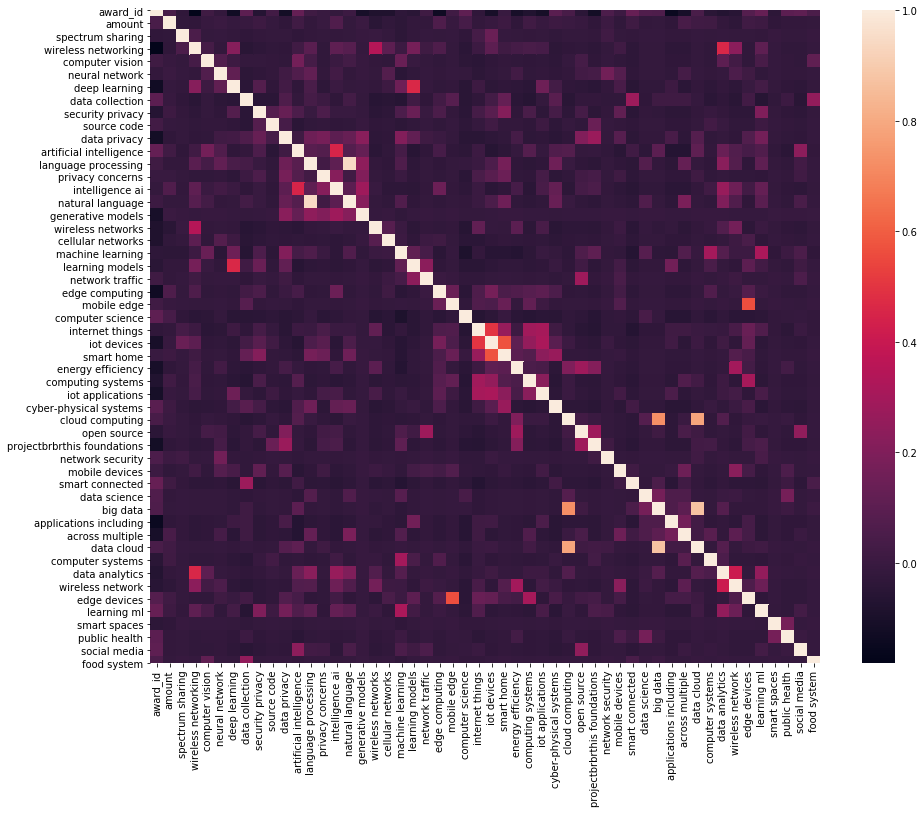

In [37]:
heatmap_generate(50, '2021')

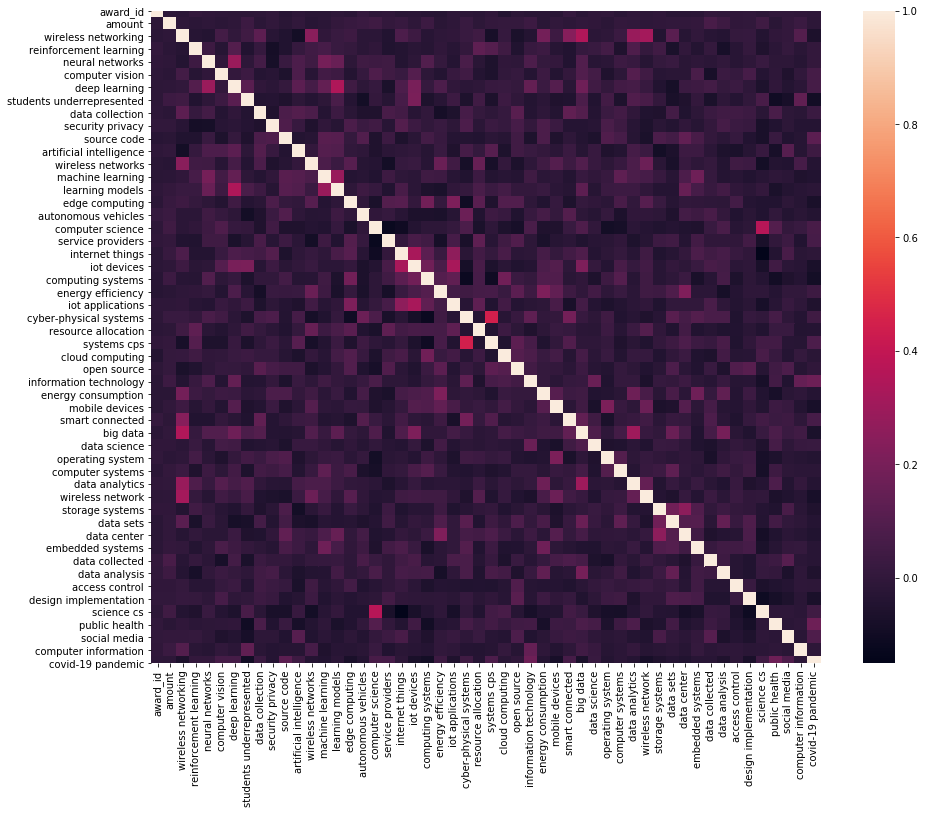

In [38]:
heatmap_generate(50, '2021', '2020', '2019', '2018', '2013')

## Find frequency of abstract per individual award

In [39]:
def df_keyword_row(df):  
    # Create a copy of df
    df1 = df.copy()
    # Iterate through dataframe
    for index, row in df1.iterrows():      
        # Get single most common word of a row
        row_single = dict_frequency_row(row, 'abstract')
        
        # Add columns for top 1 single keyword
        df1.at[index, 'top1_single_keyword'] = row_single[0][0]
        # Add columns for top 1 single keyword frequency
        df1.at[index, 'top1_single_frequency'] = row_single[0][1]
        # Add columns for top 2 single keyword
        df1.at[index, 'top2_single_keyword'] = row_single[1][0]
        # Add columns for top 2 single keyword frequency
        df1.at[index, 'top2_single_frequency'] = row_single[1][1]
        # Add columns for top 3 single keyword
        df1.at[index, 'top3_single_keyword'] = row_single[2][0]
        # Add columns for top 3 single keyword frequency
        df1.at[index, 'top3_single_frequency'] = row_single[2][1]
                
    return df1

# Constructing a trend graph

## Create a combined top words for multiple years

In [40]:
def get_frequency_phrase(year):   
    dispatcher = {'2021': top_two_phrase_abstract_2021,
                  '2020': top_two_phrase_abstract_2020,
                  '2019': top_two_phrase_abstract_2019,
                  '2018': top_two_phrase_abstract_2018,
                  '2017': top_two_phrase_abstract_2017,
                  '2016': top_two_phrase_abstract_2016,
                  '2015': top_two_phrase_abstract_2015,
                  '2014': top_two_phrase_abstract_2014,
                  '2013': top_two_phrase_abstract_2013,
                  '2012': top_two_phrase_abstract_2012,
                  '2011': top_two_phrase_abstract_2011,
                  '2010': top_two_phrase_abstract_2010,
                  '2009': top_two_phrase_abstract_2009,
                  '2008': top_two_phrase_abstract_2008,
                  '2007': top_two_phrase_abstract_2007}
    
    return dispatcher[year]

In [41]:
# Combined each year's top phrases into one single list.
# It will eliminate the union phrases.
def combine_phrases(num, *list_years):
    mergedlist = []
    for year in list_years:
        list_frequency = get_frequency_phrase(year)
        list_frequency = remove_phrases(list_frequency)
        phraseList = [values[0] for values in list_frequency[:num]]
        mergedlist = list(set(mergedlist + phraseList))
    return mergedlist

In [42]:
"""
Create a DataFrame that counts the number of frequency
of each mergedlist key phrases.

Args: list_years - list of tuples that has key phrases and its frequency
Return: df - a DataFrame with yearly data of key phrases and its frequency
"""
def get_df_years(mergedlist, *years):

    df = pd.DataFrame()
    for year in years:      
        list_frequency = get_frequency_phrase(year)
        list_in_merged = [i for i in list_frequency if i[0] in mergedlist]
        dict_from_list = dict(list_in_merged)
        for title in mergedlist:
            if title not in dict_from_list.keys():
                dict_from_list[title] = 0

        df1 = pd.DataFrame.from_dict(dict_from_list.items())    
        df1['year'] = year
        df = pd.concat([df, df1], sort= False)
    df.set_axis(['phrase', 'frequency', 'year'], axis=1, inplace=True)
    df = df.pivot('year','phrase','frequency')
    return df

In [62]:
mergedlist = combine_phrases(10, '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012')
mergedlist

['computing infrastructure',
 'energy consumption',
 'public safety',
 'artificial intelligence',
 'iot devices',
 'cyber-physical systems',
 'embedded systems',
 'data collection',
 'operating system',
 'wireless networks',
 'cloud computing',
 'access control',
 'mobile devices',
 'edge computing',
 'sensor networks',
 'storage systems',
 'covid-19 pandemic',
 'big data',
 'data analytics',
 'internet things',
 'reinforcement learning',
 'physical systems',
 'data center',
 'social media',
 'machine learning',
 'security privacy',
 'information manipulation',
 'cognitive radio',
 'resource allocation',
 'computer science',
 'computer vision',
 'deep learning']

In [63]:
df_years_merged = get_df_years(mergedlist, '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012')

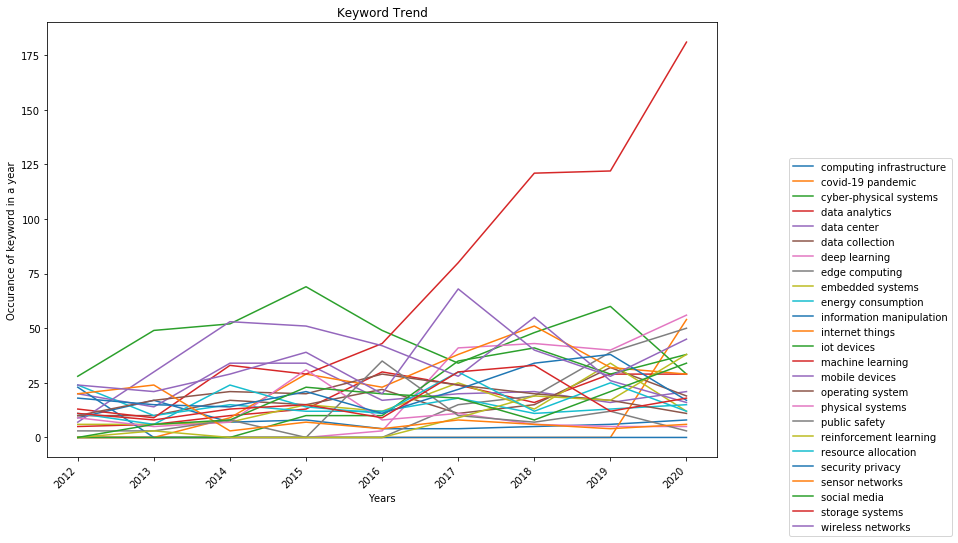

In [64]:
# plt.figure(figsize=(12,3), dpi=300)
plt.rcParams['figure.figsize'] = [12, 8]
df_years_merged.iloc[:,7:].plot()
plt.xlabel("Years")
plt.ylabel("Occurance of keyword in a year")
plt.title("Keyword Trend")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.1, .7))

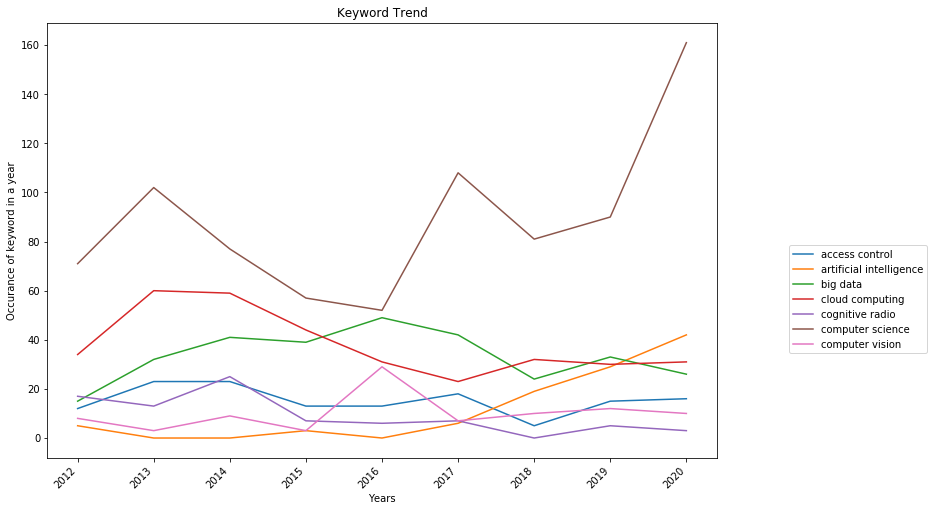

In [65]:
# plt.figure(figsize=(12,3), dpi=300)
plt.rcParams['figure.figsize'] = [12, 8]
df_years_merged.iloc[:,0:7].plot()
plt.xlabel("Years")
plt.ylabel("Occurance of keyword in a year")
plt.title("Keyword Trend")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.1, .5))

# Generate a DataFrame with award amount

In [47]:
def get_award_amount(year, phrase):
    df = get_df_year(year)
    total_amount_for_phrase = 0
    for index, row in df.iterrows():
        abstract_and_title_string = (' ').join(row['abstract']) + (' ').join(row['title'])
        if(phrase in abstract_and_title_string):
            total_amount_for_phrase += row['amount']
    return total_amount_for_phrase

In [48]:
hard_coded_phrases = df_years_merged.columns.values.tolist()

In [49]:
def get_amount_df(year, phrases):
    new_df = pd.DataFrame()
    for phrase in phrases:
        amount_to_add = get_award_amount(year, phrase)
        new_row = pd.Series(data={'amount':amount_to_add}, name=phrase)
        new_df = new_df.append(new_row)
    return new_df

In [50]:
amount_df = get_amount_df('2020', hard_coded_phrases)

In [51]:
def plot_amounts(df):
    x_values = list(amount_df.index.values.tolist())
    y_values = [row for row in amount_df['amount']]
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.bar(x_values, y_values,
            width = 0.8)
    plt.xlabel("Phrase")
    plt.ylabel("Amount (millions)")
    plt.title("Total Amount vs Phrase (2021)")
    plt.xticks(rotation=90, ha="right")
    plt.show()

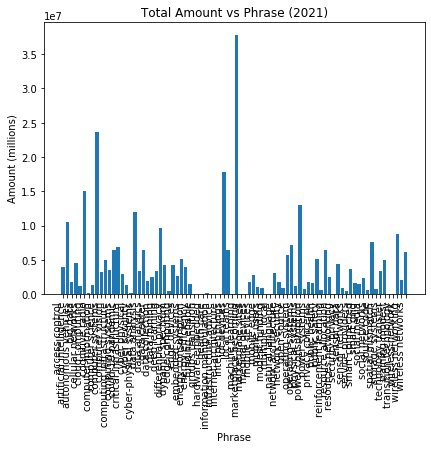

In [52]:
plot_amounts(df_2020_filtered)

## Generate a Dataframe for Machine Learning purpose

In [89]:
"""
This method prepares the dataframe for our ML purpose. Takes in two parameters, num and *years, and generates a
dataframe with frequency, award amount, and year columns per each key phrases.
Args:
num - how much key phrases we want to work with. The higher the number, more key phrases will be added to the dataframe
years - the years of research we want to analyze
Return:
dataframe with frequency, award amount, and year columns.
"""

def df_for_ML(num, *years):
    
    mergedPhrase = []    
    # Create a list of phrases for all the years in the parameter
    for year in years:
        list_frequency = get_frequency_phrase(year)
        list_frequency = remove_phrases(list_frequency)
        year_phrase = [values[0] for values in list_frequency[:num]]
        
        mergedPhrase = list(set(mergedPhrase + year_phrase))
        
    
    # Create a dataframe with years, frequency, award amount
    df = pd.DataFrame()
    for year in years:                   
        # Create a list of phrases and frequency if it matches the mergedPhrase
        list_frequency = get_frequency_phrase(year)
        list_merged = [i for i in list_frequency if i[0] in mergedPhrase]
        # Convert to dictionary
        dict_from_list = dict(list_merged)
        # Iterate through mergedPhrases and if the title is not in the phrases, set to 1.
        df_amount = pd.DataFrame()
        for title in mergedPhrase:
            if title not in dict_from_list.keys():
                dict_from_list[title] = 0
            
            # Create a dataframe with award amount as a column
            amount_to_add = get_award_amount(year, title)
            new_row = pd.Series(data={'amount':amount_to_add}, name=title)
            df_amount = df_amount.append(new_row, ignore_index=True)        
        # Convert dictionary of phrases and frequencies to a dataframe
        df1 = pd.DataFrame.from_dict(dict_from_list.items())    
        # Combine frequency df and amount df
        df1 = pd.concat([df1, df_amount], axis=1)       
        df1['year'] = year
        df = pd.concat([df, df1], sort= False)
    df.set_axis(['phrase', 'frequency', 'amount', 'year'], axis=1, inplace=True)
    return df

In [83]:
df_for_ML = df_for_ML(10, '2021', '2020', '2019', '2018','2017','2016','2015')

In [84]:
df_for_ML = df_for_ML[~(df_for_ML == 0).any(axis=1)]

In [85]:
df_for_ML.sort_values(by=['phrase'], ascending=False).to_csv('df_for_ml.csv')

In [86]:
df_for_ML.groupby(['phrase']).sum().sort_values(by=['amount'], ascending=False)

,frequency,amount
phrase,,
computer vision,89,138163383.0
data center,113,90032029.0
data analytics,157,85272317.0
storage systems,121,77433961.0
embedded systems,119,75383347.0
cloud computing,214,73114450.0
public safety,72,58586869.0
internet things,223,57707355.0
machine learning,680,54565626.0


In [92]:
df_for_cluster = df_for_ML(20, '2021', '2020', '2019', '2018','2017','2016','2015','2014','2013','2012')
df_for_cluster.groupby(['phrase']).sum().sort_values(by=['frequency'], ascending=False).to_csv('df_for_cluster.csv')